# Data Preprocessing and SVD Analysis
This notebook performs text preprocessing, TF-IDF vectorization, and dimensionality reduction using SVD/PCA on earnings call transcripts. The goal is to analyze sector-based clustering of companies.

# 1. Imports

In [1]:
# Standard Library
import os
import glob
import re
from pathlib import Path

# Data Manipulation & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

# NLP Tools
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# Matrix Completion
from fancyimpute import SoftImpute

# 2. Data Settings

---

### 2.1. Custom Stopword Compilation
This notebook defines a comprehensive set of custom stopwords to improve the quality of text analysis on earnings call transcripts. The table below summarizes each category:

| **Category**                  | **Description**                                                                 |
|------------------------------|---------------------------------------------------------------------------------|
| Company-specific         | Names and aliases of companies (e.g., "meta", "jp morgan", "nvidia")           |
| Domain-specific          | Roles and filler words common in financial speech (e.g., "ceo", "analyst")     |
| Name stopwords           | First/last names of speakers to reduce individual bias                         |
| Month/time stopwords     | Temporal terms like months and quarters ("jan", "Q1")                          |
| Transcript stopwords     | Common transcript metadata (e.g., "goldman", "quarterly", "transcript")        |
| Mid-sentence fillers     | Verbal tics and soft phrases (e.g., "uh", "yeah", "actually")                  |
| Negation/bad words       | Partial negations and contractions that add noise (e.g., "don", "isn")         |
| Platform-specific        | Product and platform terms (e.g., "azure", "youtube", "facebook")             |
| Additional English       | Reserved for any manually added stopwords beyond scikit-learn defaults         |

All sets are unified into a single `custom_stopwords` list using Python `set.union()` for streamlined filtering during preprocessing.

In [2]:
# -----------------------------
# Company-specific Stopwords
# -----------------------------
company_stopwords = {
    # 3M
    "3m",
    # AMD
    "advanced micro devices", "amd", "amd inc",
    # American Airlines
    "aal", "american airlines", "american airlines inc", "americanairlines",
    # ASML
    "asml", "asml holding", "asml holding nv",
    # Blackstone
    "blackstone", "blackstone group", "blackstone inc",
    # CBRE
    "cbre", "cbre group", "cbre inc",
    # Citigroup
    "citi", "citigroup", "citigroup inc",
    # Cushman & Wakefield
    "cushman", "cushman & wakefield", "cushman & wakefield plc", "cushman wakefield", "cushmanwakefield", "wakefield",
    # Delta Airlines
    "dal", "delta", "delta air lines", "delta air lines inc", "delta airlines",
    # Google
    "alphabet", "alphabet inc", "google", "google llc",
    # Intel
    "intel", "intel corp", "intel corp inc", "intel corporation",
    # JPMorgan Chase
    "chase", "jp morgan", "jpmc", "jpmorgan", "jpmorgan chase", "jpmorgan chase & co", "jpmorgan chase & co inc",
    # Meta
    "facebook", "facebook inc", "meta", "meta platforms", "meta platforms inc",
    # Microsoft
    "microsoft", "microsoft corp", "microsoft corp inc", "microsoft corporation", "msft",
    # Netflix
    "netflix", "netflix inc",
    # Nvidia
    "geforce", "nvidia", "nvidia corp", "nvidia corp inc", "nvidia corporation", "nvda", "rtx", "gtx", "cuda",
    # Southwest Airlines
    "southwest", "southwest airlines", "southwest airlines co",
    # TSMC
    "taiwan semiconductor", "taiwan semiconductor manufacturing", "taiwan semiconductor manufacturing company limited", "tsmc",
    # Uber
    "uber", "uber technologies", "uber technologies inc",
    # United Airlines
    "ual", "united", "united airlines", "united airlines holdings", "united airlines holdings inc",
}

# -----------------------------
# Domain-specific Stopwords
# -----------------------------
domain_stopwords = {
    # Roles
    "analyst", "board", "ceo", "chairman", "cfo", "coo", "cto", "director", "executive", "manager", "officer", "partner", "president", "vp",

    # Conversational/Filler
    "afternoon", "anybody", "anyone", "appreciate", "awesome", "comment", "comments", "consent logo", "cetera", "et cetera",
    "everyone", "guess", "guys", "hello", "hi", "inc", "just", "let", "llc", "nii", "okay", "operator", "question", "right",
    "sure", "talk", "talking", "team", "thank", "thanks", "today", "welcome", "yes", "etc", "factset", "factset copyright",
}

# -----------------------------
# Name-specific Stopwords
# -----------------------------
name_stopwords = {
    "amy", "andrew", "barnum", "bernstein", "bob", "brad", "bradley", "brian", "brett", "bruce", "carl", "chris", "dan", "daniel",
    "dara", "david", "devon", "duane", "emma", "fraser", "glen", "hauenstein", "huang", "isom", "james", "jamie", "jane", "jean",
    "jeff", "jensen", "jeremy", "joe", "john", "jon", "jordan", "khosrowshahi", "lisa", "mark", "mary", "mason", "michael", "michelle",
    "mike", "monish", "morgan", "patolawala", "peter", "phil", "philipp", "raymond", "robert", "roger", "ryan", "satya", "scott",
    "spencer", "stanley", "stephen", "steve", "su", "sundar", "tammy", "vasu", "wang", "wendell", "wennink", "wei", "william",
}

# -----------------------------
# Month/Time Stopwords
# -----------------------------
month_stopwords = {
    "april", "august", "december", "february", "january", "july", "june",
    "march", "may", "november", "october", "september",
    "apr", "aug", "dec", "feb", "jan", "jul", "jun", "mar", "may", "nov", "oct", "sep", "sept"
}

# -----------------------------
# Transcript Stopwords
# -----------------------------
transcript_stopwords = {
    "annual", "bank", "bank america", "bank of america", "barclays", "baird", "bmo", "boa", "bofa", "closing", "com",
    "copyright", "copyright global", "copyright group", "cowen", "db", "deutsche bank", "et", "fargo", "first quarter",
    "fourth quarter", "goldman", "goldman sachs", "jefferies", "ll", "marketintelligence", "month", "oq", "quarter", "quarterly",
    "republication", "reserved redistribution", "rights reserved", "second quarter", "td", "third quarter", "transcript", "ubs",
    "wells", "wells fargo", "written consent",
}

# -----------------------------
# Common Mid-sentence Fillers
# -----------------------------
common_mid_sentence_stopwords = {
    "absolutely", "actually", "ah", "essentially", "especially", "okay", "ok", "uh", "um", "yeah", "yep", "yup",
}

# -----------------------------
# Negation/Bad Words
# -----------------------------
bad_words = {
    "didn", "doesn", "don", "hadn", "hasn", "haven", "isn", "ma", "mightn", "mustn", "needn", "ve", 
}

# -----------------------------
# Platform-specific Stopwords
# -----------------------------
platform_stopwords = {
    "adsense", "airline", "airlines", "android", "azure", "chrome", "copilot", "core i7", "epyc", "facebook", "gemini", "geforce",
    "instagram", "linkedin", "llama", "metaverse", "messenger", "pixel", "radeon", "reels", "search", "skyclub", "skymiles",
    "skyteams", "snapchat", "tiktok", "twitter", "x", "x86", "youtube", "morgan stanely", "euv",
}

# -----------------------------
# Additional English Stopwords
# -----------------------------
more_english_stopwords = {
    
}

# -----------------------------
# Combine All Custom Stopwords
# -----------------------------
custom_stopwords = ENGLISH_STOP_WORDS \
    .union(domain_stopwords) \
    .union(company_stopwords) \
    .union(name_stopwords) \
    .union(month_stopwords) \
    .union(transcript_stopwords) \
    .union(common_mid_sentence_stopwords) \
    .union(platform_stopwords) \
    .union(more_english_stopwords) \
    .union(bad_words)

---

### 2.2. Company to Sector Mapping

In [ ]:
# This dictionary maps each company to its respective industry sector to enable sector-based grouping, filtering, or coloring
# in visualizations.
company_to_sector = {
    "delta": "Airlines",
    "southwest": "Airlines",
    "united": "Airlines",
    "americanairlines": "Airlines",
    "cushmanwakefield": "RealEstate",
    "cbre": "RealEstate",
    "welltower": "RealEstate",
    "amtower": "RealEstate",
    "equinix": "RealEstate",
    "amd": "Semiconductors",
    "asml": "Semiconductors",
    "intel": "Semiconductors",
    "nvidia": "Semiconductors",
    "tsmc": "Semiconductors",
    "microsoft": "Tech",
    "google": "Tech",
    "meta": "Tech",
    "netflix": "Tech",
    "uber": "Tech",
    "blackstone": "Finance",
    "citigroup": "Finance",
    "jpmc": "Finance",
    "boa": "Finance",
    "visa": "Finance",
    "3m": "ConsumerGoods",
    "costco": "ConsumerGoods",
    "henkel": "ConsumerGoods",
    "honeywell": "ConsumerGoods",
    "proctor": "ConsumerGoods",
    "walmart": "ConsumerGoods",
}


---

### 2.3. Data Settings for variables 

In [4]:
NUMBER_OF_WORDS_TO_KEEP = 2000 # Change this to keep more or fewer words
NUMBER_OF_COMPONENTS = 60 # Default is 60 for 2000 words from our SVD/PCA

data_save_file_path = Path(f"./{NUMBER_OF_WORDS_TO_KEEP}-words-kept-data/")

# 3. Text Cleaning Function

This function normalizes raw transcript text by:
- Lowercasing all characters
- Removing URLs and email addresses
- Stripping out financial boilerplate, common transcript fillers, and numbers

In [5]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Custom text cleaning + regex-based tokenization + lemmatization
def full_preprocess(text):
    # Normalize to lowercase
    text = text.lower()

    # Remove URLs and email addresses
    text = re.sub(r"http\S+|www\S+|\S+@\S+", "", text)

    # Remove financial boilerplate and common transcript filler
    text = re.sub(
        r'\b(?:q[1-4]|fy\d{2}|eps|gaap|non[- ]?gaap|ebitda|na|nm|'
        r'thank you|good morning|good afternoon|prior written consent|refinitiv|spglobal|callstreet)\b',
        '',
        text,
        flags=re.IGNORECASE
    )

    # Remove standalone numbers and currency amounts
    text = re.sub(r'\d+(?:,\d+)*\.?\d*|\$?\d+[mb]?', '', text)

    # Replace non-alphabetic characters with space
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Tokenize using regex and lemmatize
    tokens = re.findall(r'\b[a-z]{2,}\b', text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmatized)

# 4. Load Data

In [ ]:
# nltk.download('wordnet')

# --- Load and process transcript files ---
base_dir = "../../../data"
documents = []
companies = []
quarters = []

for company in os.listdir(base_dir):
    company_path = os.path.join(base_dir, company)
    if os.path.isdir(company_path):
        for file_path in glob.glob(f"{company_path}/*.txt"):
            with open(file_path, "r", encoding="latin1") as f:
                text = f.read()
            cleaned_text = full_preprocess(text)
            documents.append(cleaned_text)
            companies.append(company)
            # Extract quarter (e.g., "Q1-2023" from "Q1-2023-companyname.txt")
            filename = os.path.basename(file_path)
            quarters.append("-".join(filename.split('-')[:2]))

# Apply before vectorizing
df = pd.DataFrame({
    "company": companies,
    "quarter": quarters,
    "clean_text": documents
})

# 2. TF-IDF Vectorization with ngrams
vectorizer = TfidfVectorizer(
    stop_words=list(custom_stopwords),
    ngram_range=(1, 2),
    max_features=NUMBER_OF_WORDS_TO_KEEP,
    min_df=2,
    max_df=0.9,
    token_pattern=r'(?u)\b[a-zA-Z]{2,}\b'
)

# We use this matrix for SVD/PCA
tfidf_matrix = vectorizer.fit_transform(df["clean_text"])
tfidf_terms = vectorizer.get_feature_names_out()

/Users/christopheryang/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['advanced', 'air', 'america', 'american', 'company', 'consent', 'core', 'corp', 'corporation', 'deutsche', 'devices', 'fourth', 'global', 'group', 'holding', 'holdings', 'jp', 'limited', 'lines', 'logo', 'manufacturing', 'micro', 'nv', 'platforms', 'plc', 'redistribution', 'reserved', 'rights', 'sachs', 'second', 'semiconductor', 'stanely', 'taiwan', 'technologies', 'written'] not in stop_words.
  warnings.warn(


In [ ]:
# Check Terms
tfidf_terms

## Two Origianl Features (Just terms from TF-IDF calculation)

### Comments:
- Seems most documents do not talk about inflation much or they do with low importance (0.00 ~ 0.03)
- Considering we have a lot of tech and semiconductor companies, "cloud" is pretty sparsely referred to. It does appear mostly in the tech and semiconductor sectors which makes sense
- Again, no real meaningful structure right now.
- "Cloud" and "Inflation" do not provide a clear separation in the documents. Maybe it will have importance in higher dimensions with combinations of words

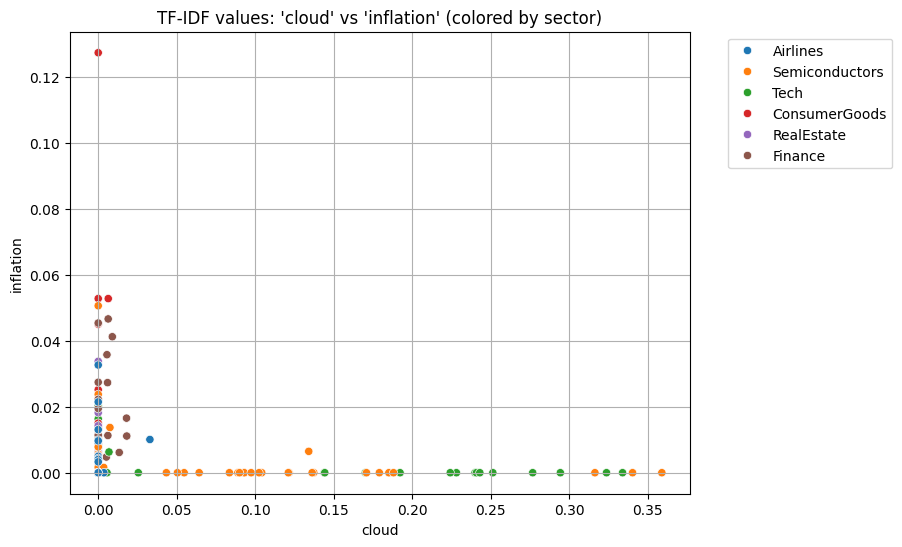

In [7]:
# --- Visualize TF-IDF distribution of two original features ---
import numpy as np
import matplotlib.pyplot as plt

# Pick two TF-IDF terms to plot
word1 = "cloud"
word2 = "inflation"

# Get their indices
idx1 = np.where(tfidf_terms == word1)[0][0]
idx2 = np.where(tfidf_terms == word2)[0][0]

# Extract those two columns and convert to dense
X_words = tfidf_matrix[:, [idx1, idx2]].toarray()

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_words[:, 0], y=X_words[:, 1], hue=df["company"].str.lower().map(company_to_sector), palette="tab10")
plt.xlabel(word1)
plt.ylabel(word2)
plt.title(f"TF-IDF values: '{word1}' vs '{word2}' (colored by sector)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# Visualizing the matrix
quarters = df["quarter"]
companies = df["company"]
sectors = df["company"].str.lower().map(company_to_sector)

tfidf_dense = tfidf_matrix.toarray()
tfidf_df = pd.DataFrame(tfidf_dense, columns=tfidf_terms)

meta_df = pd.DataFrame({
    "Company": companies,
    "Quarter": quarters,
    "Sector": sectors
})

# Combine metadata + TF-IDF features
tfidf_df_final = pd.concat([meta_df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
tfidf_df_final.to_csv('../words_TFIDF/tfidf_features.csv', index=False)
tfidf_df_final.head()

,Company,Quarter,Sector,aaron,ability,able,accelerate,accelerated,accelerated computing,accelerating,...,year end,year expect,year going,year growth,year result,year revenue,year think,year wa,yield,york
0,Delta,Q1-2024,Airlines,0.0,0.013800,0.002669,0.007088,0.003677,0.0,0.008819,...,0.000000,0.000000,0.004686,0.016251,0.000000,0.004604,0.003677,0.012586,0.015997,0.022395
1,Delta,Q4-2023,Airlines,0.0,0.004727,0.009142,0.003035,0.012595,0.0,0.003776,...,0.008099,0.016728,0.008026,0.010437,0.005205,0.000000,0.012595,0.007185,0.017123,0.000000
2,Delta,Q3-2023,Airlines,0.0,0.007122,0.018366,0.000000,0.003163,0.0,0.007585,...,0.000000,0.010081,0.004031,0.000000,0.000000,0.007920,0.003163,0.007217,0.000000,0.024079
3,Delta,Q2-2023,Airlines,0.0,0.000000,0.002829,0.003756,0.000000,0.0,0.004673,...,0.000000,0.020704,0.004967,0.000000,0.000000,0.004879,0.015589,0.000000,0.016954,0.017802
4,Delta,Q2-2024,Airlines,0.0,0.002403,0.004648,0.000000,0.006403,0.0,0.000000,...,0.008234,0.010204,0.000000,0.000000,0.005291,0.000000,0.003201,0.007305,0.006963,0.004874


# 5. SVD

The following visualizations illustrate the results of Singular Value Decomposition (SVD) applied to the TF-IDF matrix of earnings call transcripts of 20 differnet companies from different sectors.

| Left Plot | Right Plot |
|---------------|----------------|
| **2D SVD Projection**: This scatter plot shows the projection of documents onto the first two SVD components (conceptually similar to PCA). Each point represents a document, reduced to two dimensions that capture the most significant variation in term usage. Visual clustering patterns may suggest sector-based grouping. | **Cumulative Variance Explained**: This line plot shows the cumulative proportion of variance captured as more singular vectors are included. The curve demonstrates that a small number of components (e.g., ~30–40) capture the majority of the variance, indicating strong dimensionality reduction potential. |

**Key Observations:**
- The first two components show some separation between groups, indicating potential for downstream clustering or classification.
- Over 90% of the variance is explained by the first ~30 components, justifying dimensionality reduction before applying further unsupervised learning.


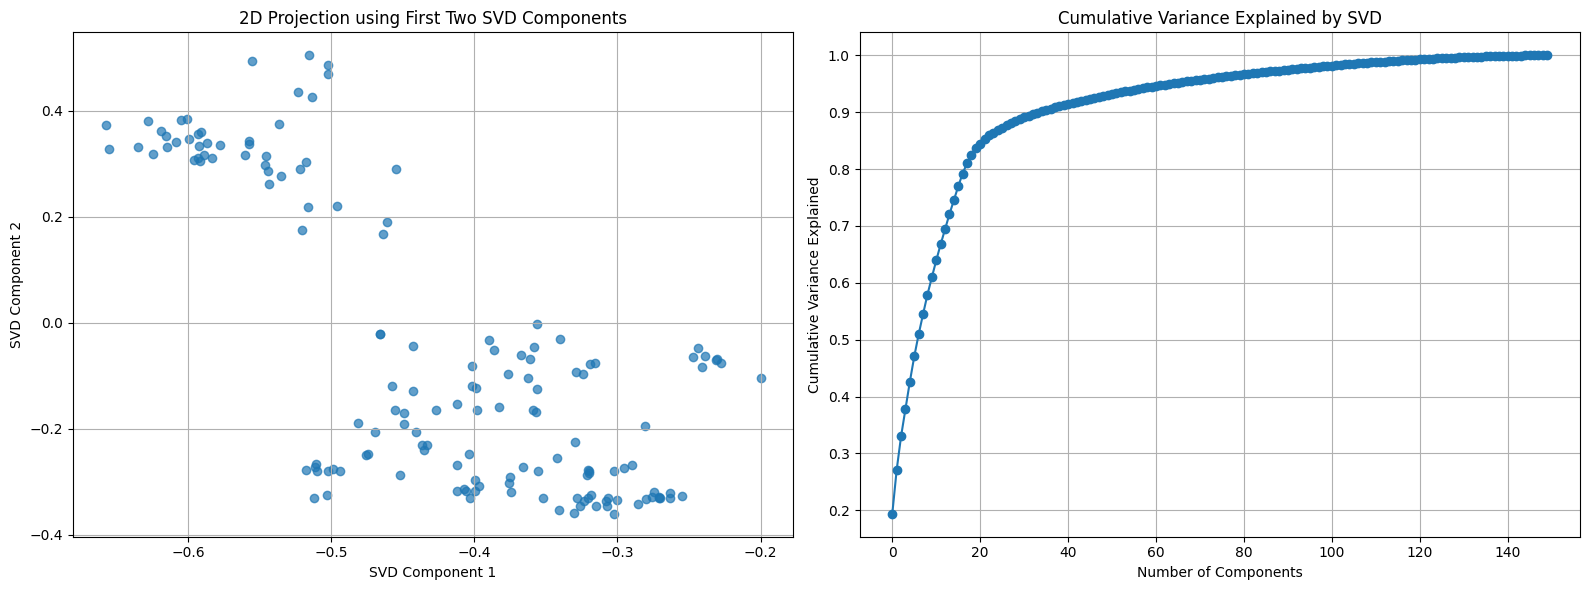

In [9]:
# Convert sparse matrix to dense
np.random.seed(42)
tfidf_dense = tfidf_matrix.toarray()

# SVD
U, S, VT = np.linalg.svd(tfidf_dense, full_matrices=False)

explained_variance = (S ** 2) / np.sum(S ** 2) # Explained variance
svd_projection = U[:, :2] @ np.diag(S[:2]) # 2D SVD Projection

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: 2D SVD Projection
axes[0].scatter(svd_projection[:, 0], svd_projection[:, 1], alpha=0.7)
axes[0].set_title('2D Projection using First Two SVD Components')
axes[0].set_xlabel('SVD Component 1')
axes[0].set_ylabel('SVD Component 2')
axes[0].grid(True)

# Plot 2: Cumulative Variance Explained
axes[1].plot(np.cumsum(explained_variance), marker='o')
axes[1].set_title('Cumulative Variance Explained by SVD')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### We only save top 60 SVD components to do Clustering

In [10]:
# Keep top 60 components
svd_60 = U[:, :NUMBER_OF_COMPONENTS] @ np.diag(S[:NUMBER_OF_COMPONENTS])

# Add metadata for our labeling purposes
svd_60_df = pd.DataFrame(svd_60, columns=[f"SVD_{i+1}" for i in range(NUMBER_OF_COMPONENTS)])
svd_60_df["Company"] = companies
svd_60_df["Sector"] = sectors
svd_60_df["Quarter"] = quarters
svd_60_df.to_csv(f"{data_save_file_path}/svd_{NUMBER_OF_COMPONENTS}_components.csv", index=False)

# 6. Truncated SVD
This section uses **Truncated Singular Value Decomposition (Truncated SVD)** to reduce the dimensionality of the sparse TF-IDF matrix. This approach is also known as Latent Semantic Analysis (LSA). It is ideal for handling large text corpora while preserving latent topic structures.

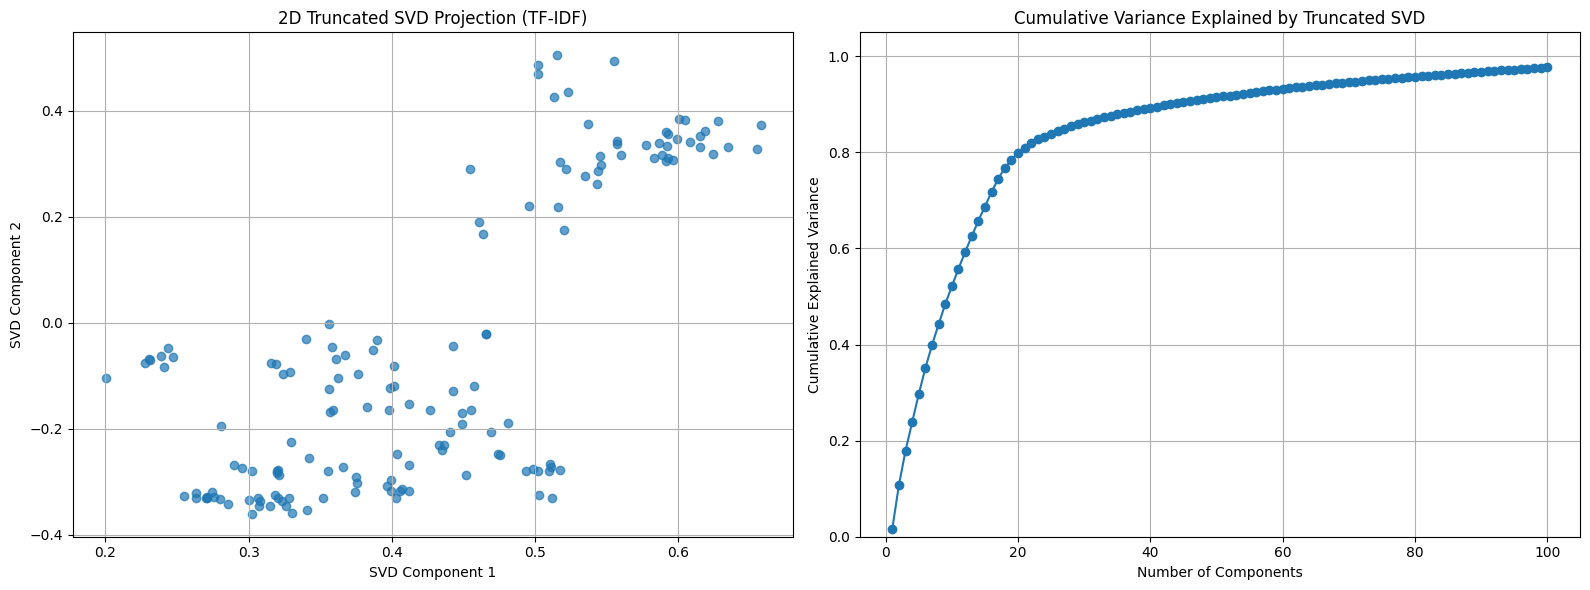

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Set random seed for reproducibility
np.random.seed(42)

# Determine number of features and safe number of SVD components
n_features = tfidf_matrix.shape[1]
n_components = min(100, n_features - 1)  # cap to 100 or one less than feature count

# Apply Truncated SVD to the TF-IDF matrix
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# Calculate explained and cumulative variance
explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: 2D Projection using first 2 SVD components
axes[0].scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], alpha=0.7)
axes[0].set_title('2D Truncated SVD Projection (TF-IDF)')
axes[0].set_xlabel('SVD Component 1')
axes[0].set_ylabel('SVD Component 2')
axes[0].grid(True)

# Plot 2: Cumulative Explained Variance
axes[1].plot(range(1, n_components + 1), cumulative_variance, marker='o')
axes[1].set_title('Cumulative Variance Explained by Truncated SVD')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_ylim([0, 1.05])  # bound y-axis to [0, 1.05]
axes[1].grid(True)

plt.tight_layout()
plt.show()

### We only save top 60 Truncated SVD components to do Clustering

In [12]:
# Extract top 60 components from the reduced matrix
top_60_svd = reduced_matrix[:, :NUMBER_OF_COMPONENTS]
top_60_df = pd.DataFrame(top_60_svd, columns=[f"SVD_{i+1}" for i in range(NUMBER_OF_COMPONENTS)])

# Add metadata for our labeling purposes
top_60_df["Company"] = companies
top_60_df["Sector"] = sectors
top_60_df["Quarter"] = quarters

# Save to CSV
top_60_df.to_csv(f"{data_save_file_path}/truncated_svd_{NUMBER_OF_COMPONENTS}_components.csv", index=False)

# 7. PCA

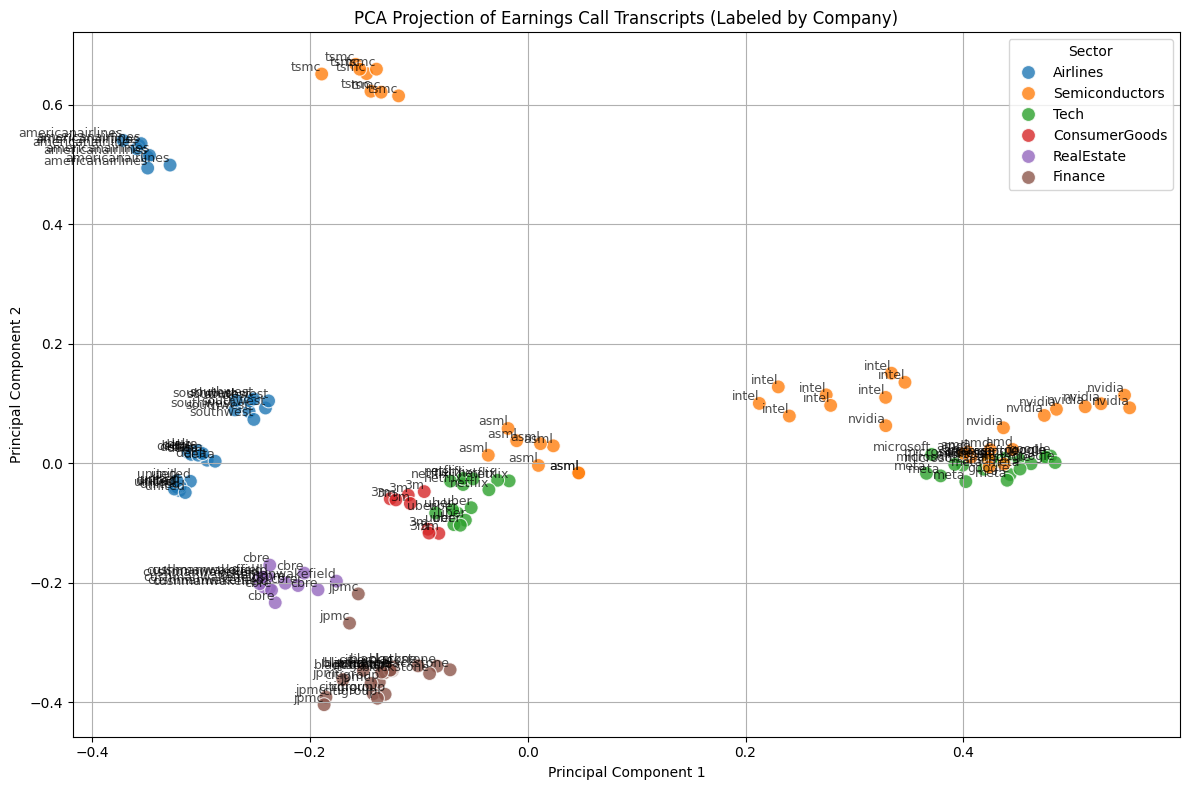

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reduce to 2 principal components
np.random.seed(42)
pca = PCA(n_components=NUMBER_OF_COMPONENTS)
pca_result = pca.fit_transform(reduced_matrix)

# Create DataFrame for plotting
df_pca = pd.DataFrame({
    "PC1": pca_result[:, 0],
    "PC2": pca_result[:, 1],
    "Company": [c.strip().lower() for c in companies],
    "Quarter": quarters
})
df_pca["Sector"] = df_pca["Company"].map(company_to_sector)

# Plot with Seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Sector", palette="tab10", s=100, alpha=0.8)

# Add company name labels
for i in range(len(df_pca)):
    plt.text(
        df_pca["PC1"][i],
        df_pca["PC2"][i],
        df_pca["Company"][i],
        fontsize=9,
        ha='right',
        va='bottom',
        alpha=0.7
    )

plt.title("PCA Projection of Earnings Call Transcripts (Labeled by Company)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


### Saving PCA data for clustering as well

In [14]:
# Save top 20 PCs (all dimensions of `pca_result`)
pca_df_all = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(NUMBER_OF_COMPONENTS)])
pca_df_all["Company"] = [c.strip().lower() for c in companies]
pca_df_all["Quarter"] = quarters
pca_df_all["Sector"] = pca_df_all["Company"].map(company_to_sector)

# Save full set for reuse
pca_df_all.to_csv(f"{data_save_file_path}/pca_{NUMBER_OF_COMPONENTS}_components.csv", index=False)

# 8. Matrix Completion

Although our TF-IDF matrix does not contain traditional "missing values" as "zero" values meaningfully represent absent terms, we simulated missingness to evaluate the performance of matrix completion techniques. This allows us to test whether the underlying structure of the text data can be effectively recovered using low-rank approximation methods.

---

### We masked 30% of the data to do the simulation.

### Comments:

- The algorithm converged after 59 iterations with a regularization parameter 𝜆 ≈ 0.078231
- The effective rank stabilized at 149, indicating a relatively low-rank structure in the data.
- The mean squared error (MSE) on the masked values was 0.00032, demonstrating that SoftImpute was able to accurately recover the missing values.
- Means the documents we collected share underlying semantic patterns

In [15]:
np.random.seed(42)

# Step 1: Simulate missing values
tfidf_dense = tfidf_matrix.toarray()
mask = tfidf_dense != 0
missing_mask = (np.random.rand(*mask.shape) < 0.30) & mask
tfidf_missing = tfidf_dense.copy()
tfidf_missing[missing_mask] = np.nan

# Step 2: Matrix completion with SoftImpute
completed_matrix = SoftImpute().fit_transform(tfidf_missing)

# Step 3: Evaluate only on masked values
true_values = tfidf_dense[missing_mask]
predicted_values = completed_matrix[missing_mask]

mse = mean_squared_error(true_values, predicted_values)
print("MSE on masked values:", mse)

[SoftImpute] Max Singular Value of X_init = 3.911539
[SoftImpute] Iter 1: observed MAE=0.000694 rank=150
[SoftImpute] Iter 2: observed MAE=0.000708 rank=150
[SoftImpute] Iter 3: observed MAE=0.000722 rank=150
[SoftImpute] Iter 4: observed MAE=0.000736 rank=150
[SoftImpute] Iter 5: observed MAE=0.000749 rank=150
[SoftImpute] Iter 6: observed MAE=0.000761 rank=150
[SoftImpute] Iter 7: observed MAE=0.000773 rank=150
[SoftImpute] Iter 8: observed MAE=0.000784 rank=150
[SoftImpute] Iter 9: observed MAE=0.000794 rank=150
[SoftImpute] Iter 10: observed MAE=0.000802 rank=150
[SoftImpute] Iter 11: observed MAE=0.000810 rank=150
[SoftImpute] Iter 12: observed MAE=0.000817 rank=150
[SoftImpute] Iter 13: observed MAE=0.000823 rank=150
[SoftImpute] Iter 14: observed MAE=0.000828 rank=150
[SoftImpute] Iter 15: observed MAE=0.000832 rank=150
[SoftImpute] Iter 16: observed MAE=0.000835 rank=149
[SoftImpute] Iter 17: observed MAE=0.000838 rank=149
[SoftImpute] Iter 18: observed MAE=0.000840 rank=149
[S

# 8.1. SVD with Matrix Completion

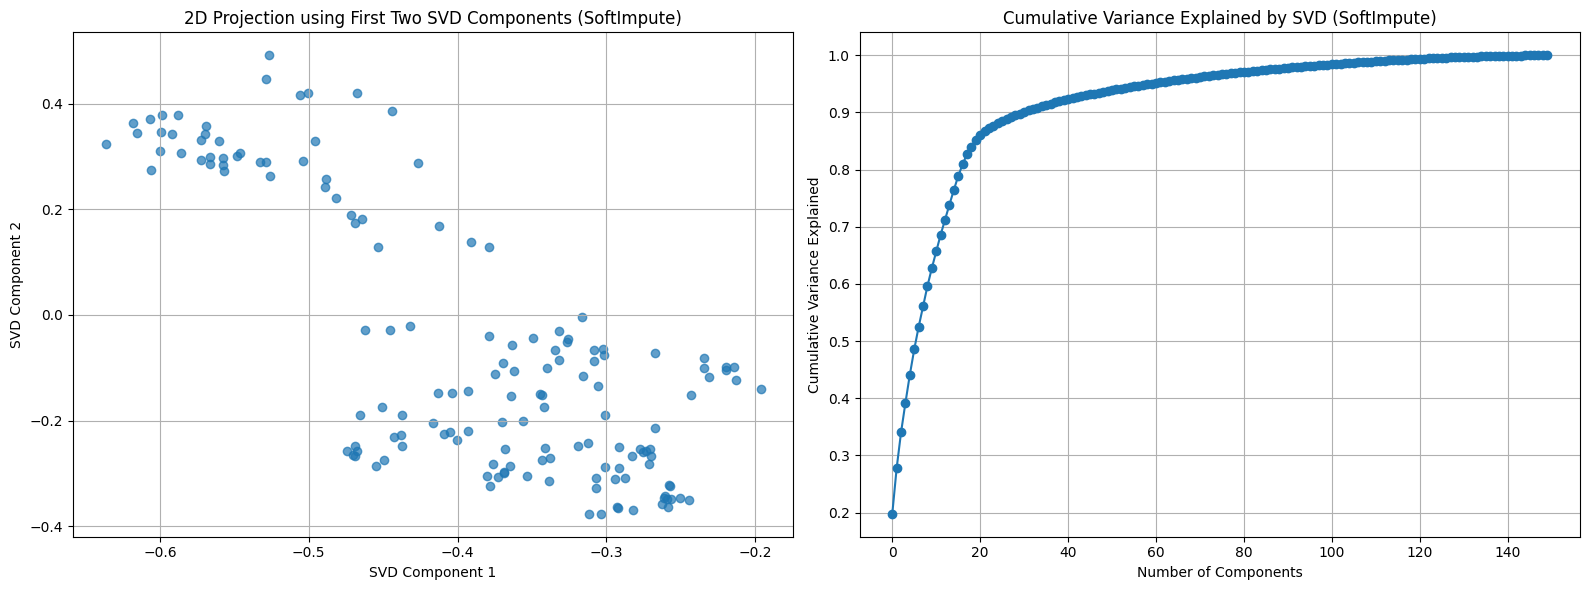

In [16]:
# 1. Set random seed for reproducibility
np.random.seed(42)

# 2. Perform SVD on the completed matrix
U, S, VT = np.linalg.svd(completed_matrix, full_matrices=False)

# 3. Compute explained variance
explained_variance = (S ** 2) / np.sum(S ** 2)  # Proportion of variance explained

# 4. Project onto first 2 components for visualization
svd_projection = U[:, :2] @ np.diag(S[:2])

# 5. Plot side-by-side: SVD projection + scree plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: 2D SVD Projection
axes[0].scatter(svd_projection[:, 0], svd_projection[:, 1], alpha=0.7)
axes[0].set_title('2D Projection using First Two SVD Components (SoftImpute)')
axes[0].set_xlabel('SVD Component 1')
axes[0].set_ylabel('SVD Component 2')
axes[0].grid(True)

# Plot 2: Cumulative Variance Explained
axes[1].plot(np.cumsum(explained_variance), marker='o')
axes[1].set_title('Cumulative Variance Explained by SVD (SoftImpute)')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### We only save top 60 Matrix Completion SVD components to do Clustering

In [17]:
# Keep top 60 components
matrix_completed_svd_60 = U[:, :NUMBER_OF_COMPONENTS] @ np.diag(S[:NUMBER_OF_COMPONENTS])

# Add metadata for our labeling purposes
matrix_completed_svd_60_df = pd.DataFrame(matrix_completed_svd_60, columns=[f"SVD_{i+1}" for i in range(NUMBER_OF_COMPONENTS)])
matrix_completed_svd_60_df["Company"] = companies
matrix_completed_svd_60_df["Sector"] = sectors
matrix_completed_svd_60_df["Quarter"] = quarters
matrix_completed_svd_60_df.to_csv(f"{data_save_file_path}/matrix_completed_svd_{NUMBER_OF_COMPONENTS}_components.csv", index=False)

# 9. t-SNE Projection of TF-IDF Features

To visually explore the semantic relationships between earnings call transcripts, we applied t-SNE (t-distributed Stochastic Neighbor Embedding) on the TF-IDF representations.

- We first reduced the TF-IDF matrix using Truncated SVD to 100 components to preserve meaningful structure. (Like how we did above in the Truncated SVD)
- Then we applied PCA to reduce to 60 components, smoothing out noise and capturing the most amount of variance.
- Finally, we applied t-SNE to project the data into 2D for visualization.

---

### Comments:

**Sector clusters are clearly visible, particularly:**
- Finance companies (blackstone, jpmc, citigroup) group closely together into a single cluster
- Real estate companies (cbre, cushmanwakefield) group together into a singler cluster nicely as well
- Airline companies also form a distinct cluster with Southwest being a slight outlier
- Semiconductor companies seem to form two groups rather than one
- Other than Uber, tech companies seem to be generally close together as one group

Some companies, such as Uber and Southwest, seem to be in a slight overlapping region, suggesting shared terminology or themes across sectors like Tech and Airline.

Also interesting to see two distinct groups in the semiconductor sector. Nvidia and TSMC appear to have different semantics than ASML, AMD, and Intel.

There are two outliers. American Airlines and TSMC seem to have varying semantics over some of their quarters, suggesting possible contextual deviation during those quarters.

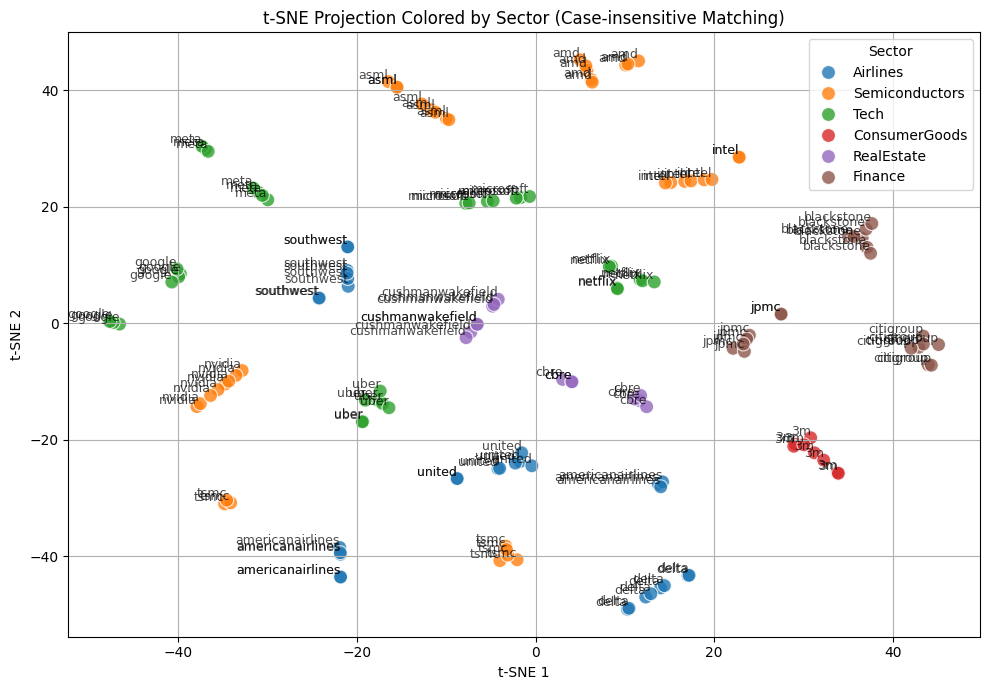

In [18]:
np.random.seed(42)

# Determine number of features and safe number of SVD components
n_features = tfidf_matrix.shape[1]
n_components = min(100, n_features - 1)  # cap to 100 or one less than feature count

# Step 2: SVD (standard dimensionality reduction before t-SNE)
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# Step 3: PCA to 10 dimensions before t-SNE
n_pca_components = min(60, reduced_matrix.shape[1])
pca = PCA(n_components=n_pca_components, random_state=42)
pca_result = pca.fit_transform(reduced_matrix)

# t-SNE usually works better on already reduced data (e.g., via SVD)
tsne = TSNE(n_components=2, perplexity=2, random_state=42, n_iter=500)
tsne_result = tsne.fit_transform(pca_result)

# Prepare dataframe for plotting
df_plot = pd.DataFrame({
    "x": tsne_result[:, 0],
    "y": tsne_result[:, 1],
    "Company": companies,
    "Quarter": quarters
})

df_plot["Company"] = df_plot["Company"].str.strip().str.lower()
df_plot["Sector"] = df_plot["Company"].map(company_to_sector)

# Plot again using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x="x", y="y", hue="Sector", palette="tab10", s=100, alpha=0.8)

for i in range(len(df_plot)):
    plt.text(
        df_plot["x"][i],
        df_plot["y"][i],
        df_plot["Company"][i],
        fontsize=9,
        ha='right',  # horizontal alignment
        va='bottom', # vertical alignment
        alpha=0.7
    )

plt.title("t-SNE Projection Colored by Sector (Case-insensitive Matching)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()